In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# from google.colab import files
import helper

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


#**Loading Train and Test Set in 80:20 Split Ratio :**

In [ ]:
# Set device configuration

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(0))

# Hyperparameters

num_epochs=25
batch_size=64
learning_rate=3e-4

transform = transforms.Compose([transforms.Scale(128),
                                    transforms.CenterCrop(128),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



# # Load Dataset

total_dataset = datasets.ImageFolder(root='../input/scene-classification', transform=transform )

print(len(total_dataset))



train_size = int(0.8 * len(total_dataset))
test_size = len(total_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(total_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

print(len(train_dataset))
print(len(test_dataset))

Tesla P100-PCIE-16GB
24335
19468
4867


In [ ]:
# Range of Image pixels after Normalization

dataiter = iter(train_dataloader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

tensor(-1.) tensor(1.)


torch.Size([3, 128, 128])


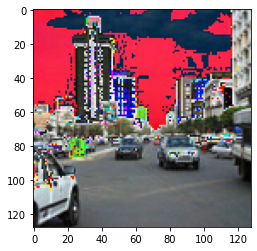

In [ ]:
img = next(iter(train_dataloader))[0][1]
print(img.shape)
plt.imshow(transforms.ToPILImage()(img))

# **Context Encoder Model Representation :**

#**Generator Model :**

In [ ]:
class Generator(nn.Module):

    def __init__(self):
        self.ngpu=1
        super(Generator, self).__init__()

        self.encoder = nn.Sequential(

            nn.Conv2d(3,64,4,2,1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64,64,4,2,1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64,128,4,2,1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128,256,4,2,1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256,512,4,2,1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512,4096,4),

            nn.BatchNorm2d(4096),
            nn.LeakyReLU(0.2, inplace=True),


            # Decoder Logic.....

            nn.ConvTranspose2d(4096,512, 4, 1, 0),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()  
          )

        self.initializeWeights()

    def forward(self,x):

        if isinstance(input, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.encoder,x, range(self.ngpu))
        else:
            output = self.encoder(x)
        return output

    def initializeWeights(self):
        for modl in self.modules():
            if isinstance(modl,nn.Conv2d):
                modl.weight.data.normal_(0.0,0.02)
                modl.bias.data.fill_(0)

            elif isinstance(modl,nn.BatchNorm2d):
                modl.weight.data.normal_(1.0,0.02)
                modl.bias.data.fill_(0)   

#**Discriminator Model :**

In [ ]:
class Discriminator(nn.Module):
  
    def __init__(self):
        self.ngpu=1
        super(Discriminator, self).__init__()

        self.d_out = nn.Sequential(

            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0),  #1 kern * (w-f+2p)/s + 1
            nn.Sigmoid()
        )
        self.initializeWeights()

    def forward(self, input):

        if isinstance(input, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.d_out, input, range(self.ngpu))
        else:
            output = self.d_out(input)

        return output.view(-1, 1)

    def initializeWeights(self):

        for modl in self.modules():
            if isinstance(modl,nn.Conv2d):
                modl.weight.data.normal_(0.0,0.02)
                modl.bias.data.fill_(0)

            elif isinstance(modl,nn.BatchNorm2d):
                modl.weight.data.normal_(1.0,0.02)
                modl.bias.data.fill_(0)

    


# **Initialize the Network and Number of Epochs :**

In [ ]:
# Initialize network 
#input_size=1*28*28

num_epochs=25

model_gen=Generator().to(device)
model_disc=Discriminator().to(device)

wt_recon=0.999

# Loss and optimizer estimation

criterion=nn.BCELoss()
criterion_mse=nn.MSELoss()


# **Using Adam Optimizer :**

In [ ]:
learning_rate=2e-4
optim_disc=optim.Adam(model_disc.parameters(),lr=1e-4, betas=(0.5,0.999))
optim_gen=optim.Adam(model_gen.parameters(),lr=5e-4, betas=(0.5,0.999))

# **Training Loop over Train Set :**

In [ ]:
from torch.autograd import Variable

ImgDim=128
overlapDim=4

input_real = torch.FloatTensor(64, 3, 128, 128)
input_cropped = torch.FloatTensor(64, 3, 128, 128)
real_center = torch.FloatTensor(64, 3,int(ImgDim/2),int(ImgDim/2))
 
cuda_avail = torch.cuda.is_available()
if(cuda_avail):
    input_real = Variable(input_real)
    input_cropped = Variable(input_cropped)
    real_center= Variable(real_center)

In [ ]:
gen_loss_lst=[]
disc_loss_lst=[]

In [ ]:
# Train Neural Network

import torchvision.utils as vutils
overlapL2Weight = 10
ld = 1

for epoch in range(num_epochs):
    gen_l=[]
    disc_l=[]
    for batch_id, (img,targets) in enumerate(train_dataloader):

        real_img = img
        real_center_img = real_img[:,:,int(ImgDim/4):int(ImgDim/4)+int(ImgDim/2),int(ImgDim/4):int(ImgDim/4)+int(ImgDim/2)]
        batch_size = real_img.size(0)

        #Initializing new image data
        input_real = torch.FloatTensor(batch_size, 3, 128, 128)
        input_cropped = torch.FloatTensor(batch_size, 3, 128, 128)
        real_center = torch.FloatTensor(batch_size, 3,int(ImgDim/2),int(ImgDim/2))

        #Image Data Loading in assigned variables.
        input_real.data.resize_(real_img.size()).copy_(real_img)
        input_cropped.data.resize_(real_img.size()).copy_(real_img)
        real_center.data.resize_(real_center_img.size()).copy_(real_center_img)

        #Cropping Image with masking certain dimension.
        input_cropped.data[:,0,int(ImgDim/4+overlapDim):int(ImgDim/4+ImgDim/2-overlapDim),int(ImgDim/4+overlapDim):int(ImgDim/4+ImgDim/2-overlapDim)] = 2*117.0/255.0 - 1.0
        input_cropped.data[:,1,int(ImgDim/4+overlapDim):int(ImgDim/4+ImgDim/2-overlapDim),int(ImgDim/4+overlapDim):int(ImgDim/4+ImgDim/2-overlapDim)] = 2*104.0/255.0 - 1.0
        input_cropped.data[:,2,int(ImgDim/4+overlapDim):int(ImgDim/4+ImgDim/2-overlapDim),int(ImgDim/4+overlapDim):int(ImgDim/4+ImgDim/2-overlapDim)] = 2*123.0/255.0 - 1.0



        img=img.to(device)
        real_center = real_center.to(device)
        batch_size=img.shape[0]

        model_disc.zero_grad()
        label=(torch.ones(batch_size)).to(device)





        # Training with real image

        output_disc=model_disc(real_center).flatten()
        ld_real=criterion(output_disc,label) # Output tends to 1
        input_cropped=input_cropped.to(device)


        # Training with fake image
        fake=model_gen(input_cropped)
        
        # Passing the cropped image through generator model 

        label=(torch.zeros(batch_size)).to(device)
        #print(fake.shape)

        output_disc=model_disc(fake.detach()).flatten()
        ld_fake=criterion(output_disc,label)  # Output tends to 0

        ld=ld_real+ld_fake   # loss of discriminator
        ld.backward()
        optim_disc.step()

        ### Train Generator :  max(log(D(G(z))))

        model_gen.zero_grad()
        label=torch.ones(batch_size).to(device)

        output=model_disc(fake).flatten()
        loss_adv=criterion(output,label)



        loss_recon=criterion_mse(fake,real_center)  # To be removed later...

        loss_gen= wt_recon * loss_recon + (1-wt_recon) * loss_adv

        loss_gen.backward()
        optim_gen.step()

        if batch_id % 100 == 0:
            print(
              f"Epoch [{epoch}/{num_epochs}] Batch {batch_id}/{len(train_dataloader)} \
                Loss D: {ld:.4f}, loss G: {loss_gen:.4f}"
            )
        
        if epoch<10:
            gen_l.append(loss_gen)
            disc_l.append(ld)

    if epoch<10:
        gen_loss_lst.append(sum(gen_l)/len(gen_l))
        disc_loss_lst.append(sum(disc_l)/len(disc_l))
    


    


Epoch [0/25] Batch 0/305                 Loss D: 1.8626, loss G: 0.6137
Epoch [0/25] Batch 100/305                 Loss D: 0.4577, loss G: 0.1146
Epoch [0/25] Batch 200/305                 Loss D: 0.0456, loss G: 0.1134
Epoch [0/25] Batch 300/305                 Loss D: 0.2407, loss G: 0.1099
Epoch [1/25] Batch 0/305                 Loss D: 0.3134, loss G: 0.1018
Epoch [1/25] Batch 100/305                 Loss D: 0.0687, loss G: 0.0933
Epoch [1/25] Batch 200/305                 Loss D: 0.0317, loss G: 0.1062
Epoch [1/25] Batch 300/305                 Loss D: 0.0163, loss G: 0.1155
Epoch [2/25] Batch 0/305                 Loss D: 0.2530, loss G: 0.1066
Epoch [2/25] Batch 100/305                 Loss D: 0.3758, loss G: 0.1006
Epoch [2/25] Batch 200/305                 Loss D: 0.1343, loss G: 0.1032
Epoch [2/25] Batch 300/305                 Loss D: 0.0100, loss G: 0.1146
Epoch [3/25] Batch 0/305                 Loss D: 0.1469, loss G: 0.1033
Epoch [3/25] Batch 100/305                 Los

In [ ]:
import os

os.mkdir(str("res2"))
os.mkdir(str("res2/real_images"))
os.mkdir(str("res2/cropped_images"))
os.mkdir(str("res2/recon_images"))

#**Testing over Test Set :**

In [ ]:
import torchvision.utils as vutils
from torch.autograd import Variable

def test(testloader):

    for batch_id, (img,targets) in enumerate(testloader):

        ImgDim=128
        overlapDim=4

        batch_size=img.shape[0]


        input_real = torch.FloatTensor(batch_size, 3, 128, 128)
        input_cropped = torch.FloatTensor(batch_size, 3, 128, 128)
        real_center = torch.FloatTensor(batch_size, 3,int(ImgDim/2),int(ImgDim/2))



        #print(img.shape)


        cuda_avail = torch.cuda.is_available()
        if(cuda_avail):
            input_real = Variable(input_real)
            input_cropped = Variable(input_cropped)
            real_center= Variable(real_center)

        input_cropped=input_cropped.to(device)
        input_real=input_real.to(device)
        real_center=real_center.to(device)

        real_img = img
        batch_size = real_img.size(0)

        input_real.data.resize_(real_img.size()).copy_(real_img)
        input_cropped.data.resize_(real_img.size()).copy_(real_img)

        input_cropped.data[:,0,int(ImgDim/4+overlapDim):int(ImgDim/4+ImgDim/2-overlapDim),int(ImgDim/4+overlapDim):int(ImgDim/4+ImgDim/2-overlapDim)] = 2*117.0/255.0 - 1.0
        input_cropped.data[:,1,int(ImgDim/4+overlapDim):int(ImgDim/4+ImgDim/2-overlapDim),int(ImgDim/4+overlapDim):int(ImgDim/4+ImgDim/2-overlapDim)] = 2*104.0/255.0 - 1.0
        input_cropped.data[:,2,int(ImgDim/4+overlapDim):int(ImgDim/4+ImgDim/2-overlapDim),int(ImgDim/4+overlapDim):int(ImgDim/4+ImgDim/2-overlapDim)] = 2*123.0/255.0 - 1.0

        fake=model_gen(input_cropped)

        recon_image = input_cropped.clone()
        recon_image.data[:,:,int(ImgDim/4):int(ImgDim/4+ImgDim/2),int(ImgDim/4):int(ImgDim/4+ImgDim/2)] = fake.data




        vutils.save_image(real_img,'./res2/real_images/val_real_samples%d.png' %(batch_id),normalize=True)
        vutils.save_image(input_cropped.data,'./res2/cropped_images/val_cropped_samples%d.png' %(batch_id),normalize=True)
        vutils.save_image(recon_image.data,'./res2/recon_images/val_recon_samples%d.png' %(batch_id),normalize=True)



In [ ]:
test(test_dataloader)


# **Plotting Average Generator-Discriminator Loss Vs Epochs Graph**

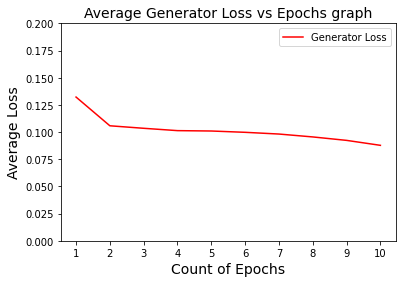

In [ ]:
epochLst=[i for i in range(1,11)]
l1=[]
l2=[]


l1=gen_loss_lst
l2=disc_loss_lst


plt.title("Average Generator Loss vs Epochs graph",fontsize='14') 

plt.plot(epochLst,l1,label = "Generator Loss",color='red')

plt.xlabel("Count of Epochs",fontsize='14')  
plt.ylabel("Average Loss",fontsize='14')  

plt.ylim(0,0.2)
plt.xticks(epochLst)

plt.legend()
plt.show()

In [ ]:
res_dataset = datasets.ImageFolder(root='./res', transform=transform )
print(len(res_dataset))

## **Saving Images Locally**

In [ ]:
!zip -m images.zip output*.png

In [ ]:
!zip -m images.zip ./res2/recon_images/val_recon_samples*.png

In [ ]:
!zip -m images.zip ./res2/real_images/val_real_samples*.png

In [ ]:
!zip -m images.zip ./res2/cropped_images/val_cropped_samples*.png

  adding: res2/cropped_images/val_cropped_samples0.png (deflated 0%)
  adding: res2/cropped_images/val_cropped_samples1.png (deflated 0%)
  adding: res2/cropped_images/val_cropped_samples10.png (deflated 0%)
  adding: res2/cropped_images/val_cropped_samples11.png (deflated 0%)
  adding: res2/cropped_images/val_cropped_samples12.png (deflated 0%)
  adding: res2/cropped_images/val_cropped_samples13.png (deflated 0%)
  adding: res2/cropped_images/val_cropped_samples14.png (deflated 0%)
  adding: res2/cropped_images/val_cropped_samples15.png (deflated 0%)
  adding: res2/cropped_images/val_cropped_samples16.png (deflated 0%)
  adding: res2/cropped_images/val_cropped_samples17.png (deflated 0%)
  adding: res2/cropped_images/val_cropped_samples18.png (deflated 0%)
  adding: res2/cropped_images/val_cropped_samples19.png (deflated 0%)
  adding: res2/cropped_images/val_cropped_samples2.png (deflated 0%)
  adding: res2/cropped_images/val_cropped_samples20.png (deflated 0%)
  adding: res2/cropped_